# Comparing Bandit Agents

This notebook compares the performance of different bandit agents.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from bart_playground.bandit.sim_util import (LinearScenario, LinearOffsetScenario, OffsetScenario, FriedmanScenario)
from compare_agents import (
    compare_agents_across_scenarios, print_summary_results, plot_comparison_results
)

In [2]:
# Create test scenarios
np.random.seed(3)
    
scenarios = {
    "Linear": LinearScenario(P=4, K=3, sigma2=1.0),
    #"LinearOffset": LinearOffsetScenario(P=4, K=3, sigma2=1.0),
    "Offset": OffsetScenario(P=4, K=3, sigma2=1.0),
    # "Offset2": OffsetScenario(P=4, K=3, sigma2=0.1),
    # "Friedman": FriedmanScenario(P=5, K=3, sigma2=1.0, lambda_val=5),
    # "Sparse": FriedmanScenario(P=50, K=3, sigma2=1.0, lambda_val=5)
}

np.random.seed(0)

In [ ]:
# Define experiment parameters
from bart_playground.bandit.bcf_agent import BCFAgent, BCFAgentPSOff
from bart_playground.bandit.basic_agents import SillyAgent, LinearTSAgent
from bart_playground.bandit.ensemble_agent import EnsembleAgent
from bart_playground.bandit.me_agents import HierTSAgent, LinearTSAgent2, LinearUCBAgent, METSAgent


n_simulations = 6  # Number of simulations per scenario
n_draws = 300      # Number of draws per simulation

# Run the comparison
results = compare_agents_across_scenarios(
    scenarios=scenarios,
    n_simulations=n_simulations,
    n_draws=n_draws,
    agent_classes=[SillyAgent, LinearTSAgent, BCFAgent, EnsembleAgent], #, BCFAgentPSOff], # LinearUCBAgent, METSAgent, HierTSAgent],
    agent_names=["Random", "LinearTS", "MBCF-TS", "MBCF+Linear"] #, "METS", "HierTS"],
)


Evaluating Linear scenario...


Simulating:   0%|          | 0/6 [00:00<?, ?it/s]

## Print Summary Results

Let's print a summary of the results for each scenario.

In [ ]:
print_summary_results(results)


=== Linear Scenario ===

Final cumulative regrets (mean ± std):
  Random: 3265.69 (±216.45)
  LinearTS: 102.78 (±21.28)
  MBCF-TS: 2411.26 (±781.60)
  MBCF+Linear: 553.62 (±74.98)

Average computation times (seconds):
  Random: 0.0068 (±0.0026)
  LinearTS: 0.0511 (±0.0072)
  MBCF-TS: 28.0748 (±1.4461)
  MBCF+Linear: 27.9722 (±1.9251)


=== Offset Scenario ===

Final cumulative regrets (mean ± std):
  Random: 966.97 (±56.55)
  LinearTS: 890.58 (±52.03)
  MBCF-TS: 240.79 (±17.37)
  MBCF+Linear: 560.88 (±126.15)

Average computation times (seconds):
  Random: 0.0062 (±0.0032)
  LinearTS: 0.0518 (±0.0057)
  MBCF-TS: 29.3265 (±0.9332)
  MBCF+Linear: 28.7698 (±0.6624)



## Visualize Results

Finally, let's visualize the cumulative regret for each agent across scenarios.

In [ ]:
# Create results directory if it doesn't exist
results_dir = "./results/agent_comparison13_greedy"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

import pickle

result_filename = os.path.join(results_dir, f"result.pkl")


In [ ]:
with open(result_filename, "wb") as file:
    pickle.dump((results, n_draws), file)


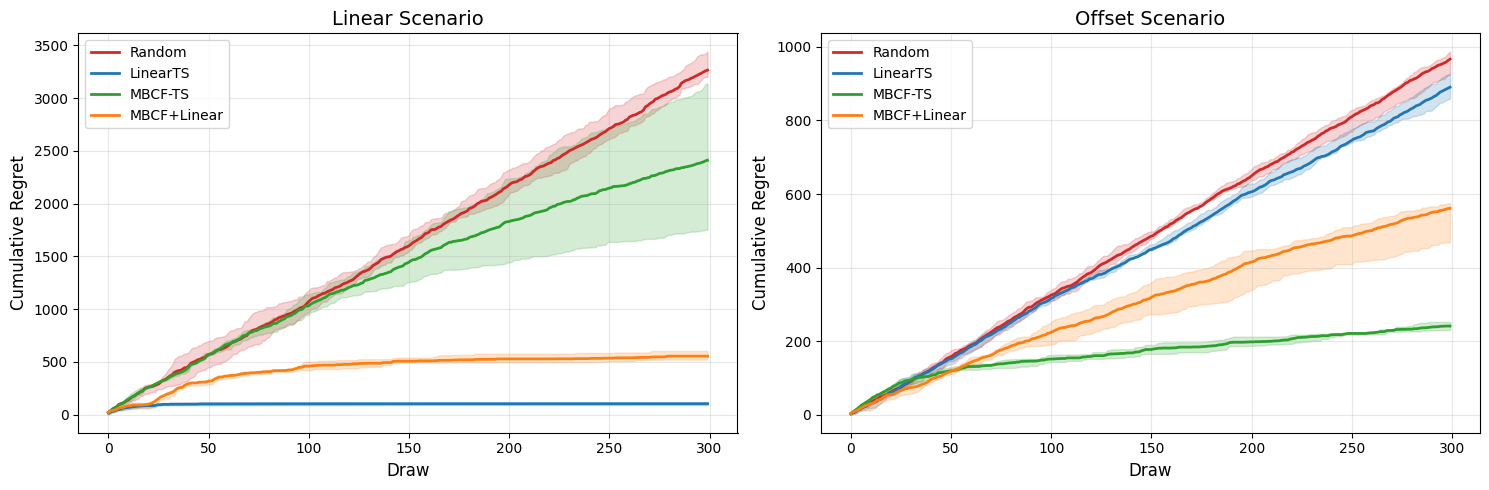

In [ ]:
# import pickle
# results_dir = "./results/agent_comparison5"
# result_filename = os.path.join(results_dir, f"result.pkl")
results, n_draws = pickle.load(file=open(result_filename, "rb"))

# Plot results and save to file
plot_comparison_results(
    results=results,
    n_draws=n_draws,
    save_path=f"{results_dir}/agent_comparison_results.png",
    show_time=False
)